# Analysis of house prices in St Albans by location

This notebook will combine several different publically available datasets to determine regions of the St Albans area (UK) that are over- or under- valued relative to the mean for the St Albans postcode (AL). 

This first notebook will use data sets from domestic household energy certificates (EPCs), sold house prices from the Land Registry and latitude / longitude data for postcodes / Unique Property Reference Number from the Ordnance Survey (OS) to create a merged dataset. 

Subsequent notebooks will analyse this merged dataset.

Accurately predicting house prices is challenging - in these notebooks we will focusing on predicting the price as a function of floor area and using geospatial analysis to determine which are the expensive / cheaper areas relative to the mean (determined by linear regression).

Future work will determine the features of the area which contribute to them being above / below the mean and ways of determing the relationship between the features of the property and the house price.

# Importing the EPC dataset

In [85]:
import pandas as pd
import numpy as np

# read into EPC data from a CSV file into a pandas dataframe
# read data from https://epc.opendatacommunities.org/files/domestic-E07000240-St-Albans.zip
# you will need to register, or use the API

epc_full_data = pd.read_csv(r'./domestic-E07000240-St-Albans/certificates.csv')

/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_5528/1875124879.py:8: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  epc_full_data = pd.read_csv(r'./domestic-E07000240-St-Albans/certificates.csv')


The EPC data contains 92 columns, most of which are not useful for this exercise. We will get an error as jupyter has to estimate the dtype for all 92 columns! 

Let's have a look at what the EPC datset contains

In [86]:
epc_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55749 entries, 0 to 55748
Data columns (total 92 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LMK_KEY                        55749 non-null  object 
 1   ADDRESS1                       55749 non-null  object 
 2   ADDRESS2                       27960 non-null  object 
 3   ADDRESS3                       4561 non-null   object 
 4   POSTCODE                       55749 non-null  object 
 5   BUILDING_REFERENCE_NUMBER      55749 non-null  int64  
 6   CURRENT_ENERGY_RATING          55749 non-null  object 
 7   POTENTIAL_ENERGY_RATING        55749 non-null  object 
 8   CURRENT_ENERGY_EFFICIENCY      55749 non-null  int64  
 9   POTENTIAL_ENERGY_EFFICIENCY    55749 non-null  int64  
 10  PROPERTY_TYPE                  55749 non-null  object 
 11  BUILT_FORM                     55747 non-null  object 
 12  INSPECTION_DATE                55749 non-null 

The EPC data contains 92 columns, most of which are not useful for this exercise. We will filter down to use the following: Total Floor Area, Number of Habitable Rooms, Total Heated Rooms, Property Type, Construction Age Band, and location data: Address, Address2, Address3, Postcode, and UPRN (Unique Property Reference Number). We need to make sure the UPRN is an numpy Int64 integer, not a float.

In [87]:
epc_df = pd.DataFrame(epc_full_data, columns=['ADDRESS','POSTCODE', 'TOTAL_FLOOR_AREA', 
                                 'NUMBER_HABITABLE_ROOMS','NUMBER_HEATED_ROOMS', 'ADDRESS1',
                                'ADDRESS2', 'ADDRESS3', 'PROPERTY_TYPE', 'CONSTRUCTION_AGE_BAND', 'UPRN', 'INSPECTION_DATE'])
epc_df['UPRN'] = epc_df['UPRN'].astype('Int64')

Let's check whether there are any missing values

In [88]:
epc_df.isnull().sum()

ADDRESS                       0
POSTCODE                      0
TOTAL_FLOOR_AREA              0
NUMBER_HABITABLE_ROOMS     6240
NUMBER_HEATED_ROOMS        6240
ADDRESS1                      0
ADDRESS2                  27789
ADDRESS3                  51188
PROPERTY_TYPE                 0
CONSTRUCTION_AGE_BAND       604
UPRN                        688
INSPECTION_DATE               0
dtype: int64

Lets check for duplicates in the UPRN column - this is where the EPC certificate has been issued more than once for the same property. This could be because the property has been sold more than once during the timeframe of EPC certificates. We will convert the inspection date to datetime object. 

In [89]:
epc_df['INSPECTION_DATE']

0        2022-10-07
1        2013-05-22
2        2009-01-21
3        2010-04-01
4        2013-09-06
            ...    
55744    2022-11-28
55745    2022-11-01
55746    2022-11-18
55747    2022-11-19
55748    2022-11-11
Name: INSPECTION_DATE, Length: 55749, dtype: object

In [90]:
epc_df['INSPECTION_DATE'] = pd.to_datetime(epc_df['INSPECTION_DATE'], format='%Y-%m-%d')

Let's look at the distribution of habitable rooms data using a seaborn count and the relationship between habitable rooms and total floor area using a box plot. 

Our selected EPC columns are all int64 types. There are no missing postcodes, first line of the addresses, or property types.  

There are no missing total_floor_areas. There are however, significant number of missing habitable rooms. Let's look at the habitable rooms data using a seaborn count and box plot versus total floor area.



Our selected EPC columns are all int64 types. There are no missing postcodes, first line of the addresses, or property types.  

There are no missing total_floor_areas. 



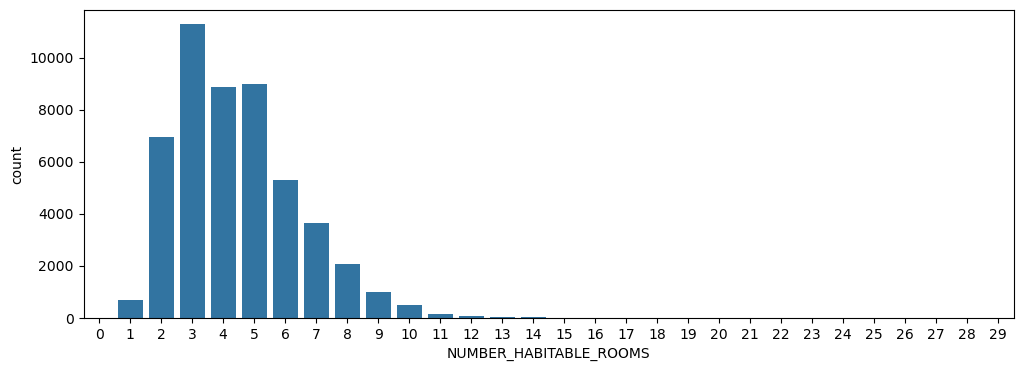

<Figure size 640x480 with 0 Axes>

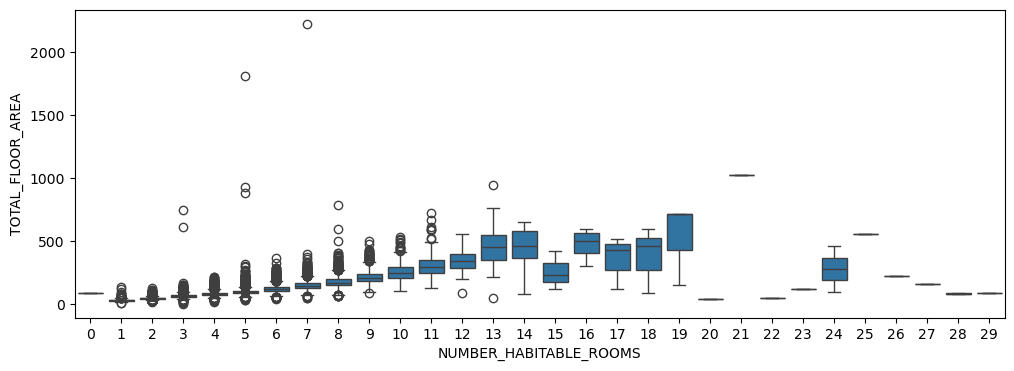

In [91]:
import matplotlib.pyplot as plt
import seaborn 
from  matplotlib.ticker import FuncFormatter
plt.figure(figsize=(12,4)) 
ax = seaborn.countplot(x="NUMBER_HABITABLE_ROOMS",data=epc_df)

# ensure x axis is set to integers
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()
plt.clf()

plt.figure(figsize=(12,4)) 
ax1 = seaborn.boxplot(data=epc_df, x='NUMBER_HABITABLE_ROOMS', y='TOTAL_FLOOR_AREA')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

There are a few things to note: There are some properties labelled as zero rooms, which is unlikely to be correct. For some number of rooms (e.g 4 and 6), there is a high number of outliers. We can see a correlation between the total floor spaces until about 13 rooms. However, from the count plot we can see there are few properties with greater than 13 rooms. If we use number of habitable rooms as a feature, we should remove the zero rooms and rooms > 13.

Let's look at the correlation between total floor area and number of habitable rooms.

In [92]:
epc_df['TOTAL_FLOOR_AREA'].corr(epc_df['NUMBER_HABITABLE_ROOMS'])

0.8094659305838451

This correlation is quite high - but as we have seen from the boxplot there are significant outliers. From now on, we will only use total floor area as a feature, but in future we will also look at including other features. 

# Importing Price data

We have downloaded from the UK Land Registry the sold prices for the St Albans postcode (AL) since 2002.  

The data can be downloaded from https://landregistry.data.gov.uk/

In [93]:
price_data_df=pd.read_csv(r'./price_data/ppd_data.csv', header=None)

price_data_df.columns =['Transaction unique identifier','Price',
                     'Date of Transfer','POSTCODE', 'property type',
                     'Old/New', 'Duration', 'SAON','PAON', 
                     'street','Locality,','Town/City',
                     'District', 'County', 
                     'PPDCategory Type', 'Record Status']


price_data_df.info()
                       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66983 entries, 0 to 66982
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Transaction unique identifier  66983 non-null  object
 1   Price                          66983 non-null  int64 
 2   Date of Transfer               66983 non-null  object
 3   POSTCODE                       66871 non-null  object
 4   property type                  66983 non-null  object
 5   Old/New                        66983 non-null  object
 6   Duration                       66983 non-null  object
 7   SAON                           8611 non-null   object
 8   PAON                           66980 non-null  object
 9   street                         66909 non-null  object
 10  Locality,                      41663 non-null  object
 11  Town/City                      66983 non-null  object
 12  District                       66983 non-null  object
 13  C

Most of the column names are self-explanatory, except: 
#PAON Primary Addressable Object Name  (typically the house number or name)

#SAON Secondary Addressable Object Name – if there is a sub-building, for example, the building is divided into flats, there will be a SAON. 

Note the same Transaction unique indentifier can be used across multiple properties (presumably if a transaction involved multiple properties). 

Let's check how complete our price dataframe is:

In [94]:
price_data_df.isnull().sum()

Transaction unique identifier        0
Price                                0
Date of Transfer                     0
POSTCODE                           112
property type                        0
Old/New                              0
Duration                             0
SAON                             58372
PAON                                 3
street                              74
Locality,                        25320
Town/City                            0
District                             0
County                               0
PPDCategory Type                     0
Record Status                        0
dtype: int64

We're missing 112 postcodes, so we'll need to take that into account later

In [95]:
price_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66983 entries, 0 to 66982
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Transaction unique identifier  66983 non-null  object
 1   Price                          66983 non-null  int64 
 2   Date of Transfer               66983 non-null  object
 3   POSTCODE                       66871 non-null  object
 4   property type                  66983 non-null  object
 5   Old/New                        66983 non-null  object
 6   Duration                       66983 non-null  object
 7   SAON                           8611 non-null   object
 8   PAON                           66980 non-null  object
 9   street                         66909 non-null  object
 10  Locality,                      41663 non-null  object
 11  Town/City                      66983 non-null  object
 12  District                       66983 non-null  object
 13  C

Let's look at the price_data_df, and we can remove some entries which fail a sanity check.

In [96]:
price_data_df.head()

,Transaction unique identifier,Price,Date of Transfer,POSTCODE,property type,Old/New,Duration,SAON,PAON,street,"Locality,",Town/City,District,County,PPDCategory Type,Record Status
0,2403D606-A793-4EAE-9771-93B96965E20E,500000,2015-01-30,AL1 1AJ,T,N,F,NaN,2,ORIENT CLOSE,NaN,ST ALBANS,ST ALBANS,HERTFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...
1,79A74E21-9273-1289-E053-6B04A8C01627,700000,2018-09-21,AL1 1AJ,T,N,F,NaN,5,ORIENT CLOSE,NaN,ST ALBANS,ST ALBANS,HERTFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...
2,C40A8A59-106B-440E-87F1-916CA5BFF4BA,470000,2013-01-10,AL1 1AJ,T,N,F,NaN,5,ORIENT CLOSE,NaN,ST ALBANS,ST ALBANS,HERTFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...
3,7011B109-623C-8ED6-E053-6B04A8C075C1,570000,2018-05-18,AL1 1AJ,S,N,F,NaN,6,ORIENT CLOSE,NaN,ST ALBANS,ST ALBANS,HERTFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...
4,C11B17CC-8A4F-4406-9871-617FDD7278C3,375000,2012-08-01,AL1 1AJ,S,N,F,NaN,9,ORIENT CLOSE,NaN,ST ALBANS,ST ALBANS,HERTFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...


There are several things we can check to help with subsequent matching. If there are multiple entries for the same property with the same Date of Transfer but with different Price, something has gone wrong with the entry and needs to be removed. Alternatively, if there are multiple entries with the same address, Price and transfer date - we only need to consider one. Let's filter the data. 

In [111]:
# Remove rows where the same 'PAON', 'SAON', 'street', and 'Date of Transfer' have different 'Price'
# Group by 'PAON', 'SAON', 'street', 'Date of Transfer', and count distinct 'Price'
initial_size = price_data_df.shape[0]
price_conflict_groups = price_data_df.groupby(['PAON', 'SAON', 'street', 'Date of Transfer'])['Price'].nunique()

# Identify the groups where more than one distinct 'Price' exists
conflicting_price_groups = price_conflict_groups[price_conflict_groups > 1].index

# Remove rows with price conflicts from the dataframe
price_data_df = price_data_df[~price_data_df.set_index(['PAON', 'SAON', 'street', 'Date of Transfer']).index.isin(conflicting_price_groups)]

# Keep only the latest 'Date of Transfer' for same 'PAON', 'SAON', 'street', and 'Price' and 'Transaction unique indentifier' 
# Sort by 'Date of Transfer' in descending order, so the latest date comes first
price_data_df.sort_values(by='Date of Transfer', ascending=False, inplace=True)

# Drop duplicates based on 'PAON', 'SAON', 'street', 'Price', keeping only the first occurrence (latest date)
price_data_df.drop_duplicates(subset=['PAON', 'SAON', 'street', 'Price', 'Transaction unique identifier'], keep='first', inplace=True)

# Keep only one entry for identical rows (same 'PAON', 'SAON', 'street', 'Price', 'Date of Transfer') 
price_data_df.drop_duplicates(subset=['PAON', 'SAON', 'street', 'Price', 'Date of Transfer'], keep='first', inplace=True)

resulting_size = price_data_df.shape[0]
print("SIZES", initial_size, resulting_size)
print("REMOVED", initial_size - resulting_size, "ENTRIES FROM PRICE DATAFRAME")


SIZES 66800 66800
REMOVED 0 ENTRIES FROM PRICE DATAFRAME


# Data matching 
We need to merge the Land Registry and EPC dataframes, but there is no key that is consistent across the dataframes

So instead we'll need to do some partial matches.

Postcodes should match between the dataframes, but postcodes are reported to have on average 15 properties within them (and upto 100). 

To identify individual properties within a postcode, we will attempt to match the following:

LAND REGISTRY DATA: \
PAON - Primary Addressable Object Name, usually the street number and name \
SAON - Secondary Addressable Object Name; usually flat number \
street name 

with 

EPC DATA: \
ADDRESS1:  HOUSE NUMBER, OR HOUSE NAMES, OR FLAT NUMBER, SOMETIMES STREET AS WELL \
ADDRESS2:  NORMALLY STREET, COULD BE BUILDING \
ADDRESS3:  CAN BE STREET, CAN BE TOWN/CITY


In [98]:
# lets remove all postcodes not in St Albans: 
AL_epc_df=epc_df.loc[epc_df['POSTCODE'].str.startswith('AL')]

# remove those addresses with missing postcodes from the price data and then select only those with a St Albans postcode. 
# This removes the entries with no POSTCODE

price_data_df = price_data_df[price_data_df['POSTCODE'].notnull()]
AL_price_df = price_data_df.loc[price_data_df['POSTCODE'].str.startswith('AL')]
AL_epc_df.info()
AL_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55461 entries, 0 to 55748
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ADDRESS                 55461 non-null  object        
 1   POSTCODE                55461 non-null  object        
 2   TOTAL_FLOOR_AREA        55461 non-null  int64         
 3   NUMBER_HABITABLE_ROOMS  49350 non-null  float64       
 4   NUMBER_HEATED_ROOMS     49350 non-null  float64       
 5   ADDRESS1                55461 non-null  object        
 6   ADDRESS2                27733 non-null  object        
 7   ADDRESS3                4508 non-null   object        
 8   PROPERTY_TYPE           55461 non-null  object        
 9   CONSTRUCTION_AGE_BAND   54895 non-null  object        
 10  UPRN                    54820 non-null  Int64         
 11  INSPECTION_DATE         55461 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(1

To merge the datasets, we're going to need to create new columns where we combine SAON and PAON in the AL_prices_df dataframe, and merge with the ADDRESS column in the AL_price_data dataframe.

Our procedure to match (which *could* improved) is to match postcodes, then match the numbers in the SAON / PAON in the AL_price_df to the numbers in ADDRESS column in the AL_price_data dataframe. There are scenarios where this could lead to multiple address with the same new identity - for example, if a postcode contains multiple streets with the same house numbers. This will fail where there are no numbers at all in the address (for example, purely a housename), so this could be improved in the next version. 

To ensure consistency, will need to add zeros where there is no entry in the SAON / PAON column.

In [99]:
AL_price_df['SAON'] = AL_price_df['SAON'].astype(str)
AL_price_df['PAON'] = AL_price_df['PAON'].astype(str)

print(AL_price_df.shape)

print(AL_epc_df.shape)

(66800, 16)
(55461, 12)


We can estimate the number of times a property has been sold multiple times. This is small compared to the number of sold prices, but we will need to ensure we have the nearest EPC data to the Date of Transfer. 

In [100]:
AL_price_df['NUMBERS_1'] = AL_price_df['SAON'] + " , " + AL_price_df['PAON']
AL_price_df['NUMBERS_SAON'] = AL_price_df['NUMBERS_1'].str.findall('(\d+[^,\s]*)').str[-2].fillna('0')
AL_price_df['NUMBERS_PAON'] = AL_price_df['NUMBERS_1'].str.findall('(\d+[^,\s]*)').str[-1].fillna('0')

sold_date_counts = AL_price_df.groupby(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE'])['Date of Transfer'].nunique()
multiple_sold_dates = sold_date_counts[sold_date_counts > 1]

# Get the number of UPRNs with multiple distinct 'Date of Transfer'
num_multiple_sold_dates = multiple_sold_dates.shape[0]

print(f"Number of properties with different Date of Transfer values: {num_multiple_sold_dates}")

Number of properties with different Date of Transfer values: 18141


In [101]:
AL_epc_df.loc[:,'NUMBERS_SAON'] = AL_epc_df['ADDRESS'].str.findall('(\d+[^,\s]*)').str[-2].fillna('0')
AL_epc_df.loc[:,'NUMBERS_PAON'] = AL_epc_df['ADDRESS'].str.findall('(\d+[^,\s]*)').str[-1].fillna('0')


/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_5528/2350967641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AL_epc_df.loc[:,'NUMBERS_SAON'] = AL_epc_df['ADDRESS'].str.findall('(\d+[^,\s]*)').str[-2].fillna('0')
/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_5528/2350967641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AL_epc_df.loc[:,'NUMBERS_PAON'] = AL_epc_df['ADDRESS'].str.findall('(\d+[^,\s]*)').str[-1].fillna('0')


We can check the amount properties that have the NUMBERS_SAON, NUMBERS_PAON and POSTCODE but multiple UPRNs in the AL EPC dataframe. This tells us the number of properties that have the same merging columns, but are actually different properties. We see these make up < 1% of the total properties. We'll drop these cases, as it is a small number and as the properties could be very different, despite being in the same postcode.  

In [102]:
duplicate_uprn_groups = AL_epc_df.groupby(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE'])['UPRN'].nunique()

# Filter groups where there is more than one unique UPRN
multiple_uprn = duplicate_uprn_groups[duplicate_uprn_groups > 1]

# Get the count of such cases
num_multiple_uprn = multiple_uprn.shape[0]

print(f"Number of cases with more than one UPRN: {num_multiple_uprn}")

total_groups = AL_epc_df.groupby(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE']).ngroups

# Fraction of cases with more than one unique UPRN
fraction_multiple_uprn = multiple_uprn.shape[0] / total_groups

print(f"Fraction of cases with more than one UPRN: {fraction_multiple_uprn}")

groups_with_multiple_uprn = multiple_uprn.index

# Create a mask to identify the rows to drop
mask = AL_epc_df.set_index(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE']).index.isin(groups_with_multiple_uprn)

AL_epc_df.drop(AL_epc_df.loc[mask].index, inplace=True)

print(f"Number of rows after dropping in-place: {AL_epc_df.shape[0]}")


Number of cases with more than one UPRN: 276
Fraction of cases with more than one UPRN: 0.006729081334113517
Number of rows after dropping in-place: 54454


/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_5528/3712724687.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AL_epc_df.drop(AL_epc_df.loc[mask].index, inplace=True)


There are many duplicates in the properties of the AL_price_df dataframe - we can assume this is where a property has been sold multiple times in the time period of the price data. 

We can assume that the EPC certificate is issued every time a property is sold, but this hasn't always been the case. Note properties can be extended (and hence floor area will increase) between sales. It could also be reduced. 

We need to therefore find the corresponding EPC certificate closest to when the property is sold. 

In [103]:
inspection_date_counts = AL_epc_df.groupby('UPRN')['INSPECTION_DATE'].nunique()

# Filter to get only UPRNs that have more than one distinct 'INSPECTION_DATE'
multiple_inspection_dates = inspection_date_counts[inspection_date_counts > 1]

# Get the number of UPRNs with multiple distinct 'INSPECTION_DATE'
num_multiple_inspection_dates = multiple_inspection_dates.shape[0]

print(f"Number of UPRNs with different INSPECTION_DATE values in the AL_epc_df dataframe: {num_multiple_inspection_dates}")


Number of UPRNs with different INSPECTION_DATE values in the AL_epc_df dataframe: 11709


We'll merge in our newly created 'NUMBERS_SAON' and 'NUMBERS_PAON' columns, along with 'POSTCODE'

In [104]:
# convert the Date of Transfer column in AL_price_df to a datatime dtype, for comparison with INSPECTION_DATE in the AL_epc_df
AL_price_df['Date of Transfer'] = pd.to_datetime(AL_price_df['Date of Transfer'])

merged_df = pd.merge(AL_price_df, AL_epc_df, on=['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE'], how='inner')

In the merge, where there are multiple EPC certificates for each property, we'll calculate the difference in time between the Date of Transfer and the Inspection Date, and pick the closest one.

In [105]:
# Step 2: Calculate the absolute difference between the dates
merged_df['date_diff'] = (merged_df['Date of Transfer'] - merged_df['INSPECTION_DATE']).abs()
s = merged_df.duplicated(subset=['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE'])

print(merged_df.shape)
merged_df = merged_df.sort_values(by=['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'UPRN', 'Date of Transfer', 'date_diff'])


(66680, 31)


In [106]:
# Sort by the 'NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer' to find the nearest date match

grouped_df = merged_df.groupby(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer']).size()

# uncomment the following to see how selecting the nearest EPC data works for selected example
#transaction_id = 200001902702
#selected_columns = ['UPRN', 'Transaction unique identifier', 'NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer', 'INSPECTION_DATE', 'date_diff']
#filtered_data = merged_df2[merged_df2['UPRN'] == transaction_id][selected_columns]
#print(filtered_data)

# Find duplicates
#duplicate_groups = grouped_df[grouped_df > 1].index

# Get the rows belong to these duplicate groups
#duplicate_rows = merged_df2[merged_df2.set_index(['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer']).index.isin(duplicate_groups)]

# Print the rows with duplicate subsets
#print(duplicate_rows[['UPRN', 'Transaction unique identifier', 'NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer', 'INSPECTION_DATE', 'date_diff']])

# Drop the duplicates to keep only the row with the smallest date difference for each group
result_df = merged_df.drop_duplicates(subset=['NUMBERS_SAON', 'NUMBERS_PAON', 'POSTCODE', 'Date of Transfer'], keep='first')

# we'll drop the 'date_diff' column - not needed
result_df = result_df.drop(columns=['date_diff'])

# Merging with coordinate data 
Now we have the merged EPC and price dataframe, we can add coordinates to the properties, using data from the Ordinance Survey, which relates the UPRN to coordinates

In [107]:
UPRN_to_lat_long_df = pd.read_csv(r'./osopenuprn_202409_csv/osopenuprn_202409.csv') 

In [108]:
UPRN_to_lat_long_df = pd.read_csv(r'./osopenuprn_202409_csv/osopenuprn_202409.csv') 

In [81]:
UPRN_to_lat_long_df = pd.read_csv(r'./osopenuprn_202409_csv/osopenuprn_202409.csv') 
result_df_lat_long = pd.merge(result_df, UPRN_to_lat_long_df , on=['UPRN'], how='inner')

In [109]:
result_df_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47911 entries, 0 to 47910
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction unique identifier  47911 non-null  object        
 1   Price                          47911 non-null  int64         
 2   Date of Transfer               47911 non-null  datetime64[ns]
 3   POSTCODE                       47911 non-null  object        
 4   property type                  47911 non-null  object        
 5   Old/New                        47911 non-null  object        
 6   Duration                       47911 non-null  object        
 7   SAON                           47911 non-null  object        
 8   PAON                           47911 non-null  object        
 9   street                         47892 non-null  object        
 10  Locality,                      26730 non-null  object        
 11  Town/City      

We'll output our new combined dataset: 

In [110]:
result_df_lat_long.to_csv('./merged_datasets.csv')